### **1. Sujet 4 : Secteurs data mining US**

#### **Consignes :**
le but de ce projet est de quantifier la relation entre les performances boursières et les données fondamentales
pour chaque question on donnera une structure adéquate aux données pour faciliter les traitements de calcul

quel est le coefficient de corrélation de chaque donnée fondamentale avec les performances ?
a l'aide d'outils adéquats (ACP, AFD, regression linéaire…), mettre en évidence l'impact des données fondamentales sur les performances des indices sectoriels
y a-t-il des spécificités sectorielles ou de thème d'investissement qui se dégagent ?
y a-t-il des années ou les données fondamentales prédisent mieux les performances et pour quels secteurs?
proposer une méthode de scoring pour sélectionner les secteurs ou investir en début de chaque année
proposer des pistes d'amélioration de la méthode


#### **Méthodes utilisées :**
- Table de corrélation
- Analyse en Composante Principale (ACP)
- Régression linéaire

## **2. Importer Les données préalablement préparées dans Excel**
**Modification apportées via Excel :**  
Les modifications faites sur excel sont uniquement d'ordre pratique et pour faciliter le traitement sur python
- Simplifier des noms des lignes et colonnes
    - Supprimer les mentions "S/P 500" ; "SEC"...
- Ajouter la colonne date afin de regrouper les ratios financiers et les rendements boursiers par année
    - Retirer un an pour les lignes "% YTD Change" afin de pouvoir traiter les ratios financiers propres à chaque année
- Remplacer " " par "" pour une meilleure identification des valeurs manquantes dans le jeu de données sur python

In [236]:
# Installer les librairies nécessaires
!pip install IPython ipywidgets matplotlib numpy pandas seaborn scikit-learn pandas numpy


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Matteo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [238]:
import os
import pandas as pd

# Charger le dataset
df = pd.read_csv(os.getcwd()+"/Dataset.csv", index_col="Metrics")
df.head().round(3)

,Date,Energy,Utilities,Materials,Financials,Industrials,Health Care,Real Estate,Consumer Staples
Metrics,,,,,,,,,
% Change YTD,31/12/2017,-0.165,0.055,-0.122,-0.104,-0.107,0.100,-0.009,-0.067
EPS NTMA Growth 1 year,31/12/2017,35.724,5.282,19.394,15.715,9.252,6.463,6.637,7.676
Price to Earnings,31/12/2017,25.509,17.815,17.997,14.761,19.566,16.687,18.006,20.546
Price to Book Value,31/12/2017,1.977,1.906,2.711,1.493,4.811,3.627,3.362,5.127
Price to Cash Flow,31/12/2017,9.262,7.350,11.406,NaN,13.511,14.052,17.885,15.666


#### **2. Panélisation par secteur**

**Justification de l’analyse par secteur:**  
L’étude a été panélisée par secteur pour mieux capter les dynamiques propres à chaque industrie. Cette approche s’impose pour plusieurs raisons :  

- **Spécificités sectorielles** : Chaque secteur a des modèles économiques et financiers distincts, rendant certains ratios plus pertinents que d’autres (*Price to Book Value* pour les banques, *Net Debt/EBITDA* pour l’énergie).  
- **Hétérogénéité des valorisations** : Un même ratio peut avoir une signification différente selon le secteur (*P/E de 15 normal pour une banque, mais faible pour la tech*).  
- **Sensibilité aux cycles macroéconomiques** : L’influence des taux d’intérêt, de l’inflation ou des prix des matières premières varie d’un secteur à l’autre.  
- **Optimisation des stratégies d’investissement** : Une analyse sectorielle permet d’identifier les moteurs de performance spécifiques et d’adapter la sélection d’actifs en conséquence.  

In [ ]:
# Sélection du secteur pour le reste de l'étude
sector = 'Consumer Staples'

# Sélection du secteur et de la colonne "Date"
dataset = df[[sector, 'Date']]

# Réorganisation des données : pivotage et suppression des valeurs manquantes
dataset = dataset.reset_index().pivot(index='Metrics', columns='Date').dropna()

# Supression de la dimension secteur et transposition des axes
dataset = dataset[sector].transpose()

In [241]:
dataset.describe()

Metrics,% Change YTD,Assets/Equity,Dividend Payout,Dividend Yield,EBIT Margin,EBITDA Margin,EPS NTMA Growth 1 year,Enterprise Value to EBIT,Enterprise Value to EBITDA,Enterprise Value to Sales,Gross Margin,Net Debt/EBITDA,PEG,Price to Book Value,Price to Cash Flow,Price to Earnings,Price to Free Cash Flow,Price to Sales,Return on Equity
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.103698,2.681295,49.392199,2.989085,10.073512,12.316070,7.617559,12.688766,10.373305,1.275253,29.555685,1.414632,1.938617,4.014119,12.492646,16.661897,18.573684,1.094656,24.101335
std,0.105565,0.189328,5.489819,0.179670,0.293030,0.331599,1.578764,2.131903,1.712962,0.198164,0.723156,0.224916,0.551977,0.668000,2.048549,2.747075,2.165131,0.178696,0.838276
min,-0.066717,2.430804,42.601798,2.723079,9.628450,11.803058,5.277322,10.369939,8.511416,1.033704,28.454544,1.093059,1.340692,3.129956,10.183389,13.587065,16.236273,0.880978,22.569964
25%,0.057036,2.577559,44.898834,2.884676,9.957727,12.147051,6.784050,10.734569,8.788400,1.125495,29.131427,1.255429,1.447529,3.443672,10.647649,14.230575,16.573812,0.954989,23.887381
50%,0.109817,2.666519,47.818043,3.010271,10.089169,12.323587,7.649314,12.148713,9.956170,1.216365,29.376722,1.354442,1.762404,3.966329,12.021057,15.845222,18.104245,1.037807,24.115170
75%,0.169347,2.760750,54.923366,3.147699,10.191690,12.462071,8.438904,14.716315,12.010727,1.439815,30.107854,1.639006,2.442072,4.490649,14.328972,19.322055,20.823584,1.243777,24.693242
max,0.285289,2.991300,57.035750,3.171024,10.584708,12.926601,9.917736,15.738997,12.865571,1.593237,30.747401,1.727999,2.720721,5.126537,15.665557,20.546339,21.263382,1.375095,25.263267


## 3. Table de corrélation de l'évolution au cours des années des valeurs fondamentales du secteur sélectionné

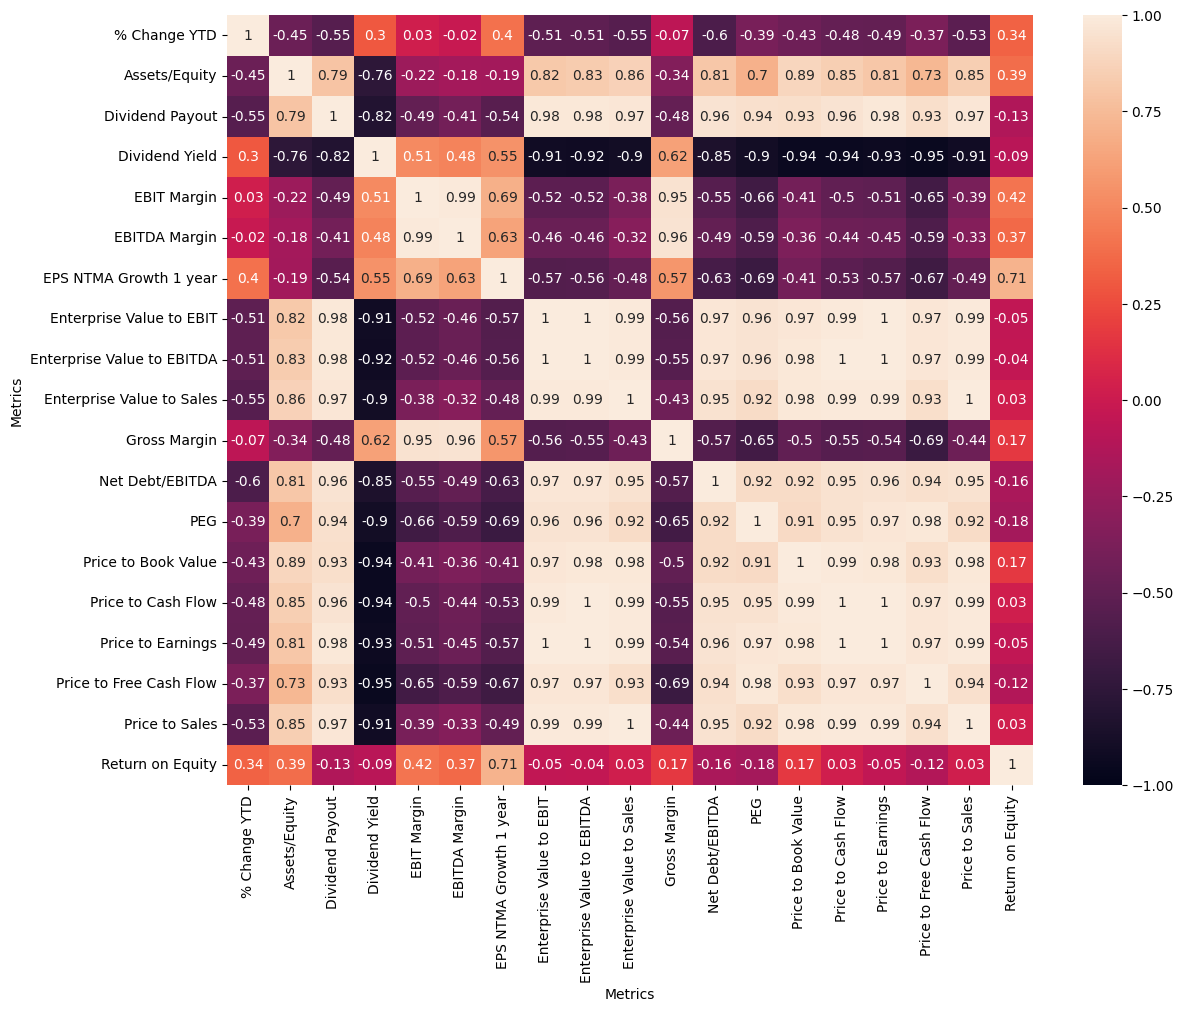

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des variations en pourcentage
dataset_pct_change = dataset.pct_change()

# Ajustement de la taille de la figure
plt.gcf().set_size_inches(13, 10)

# Affichage de la heatmap de corrélation
sns.heatmap(dataset.corr().round(2), vmin=-1, vmax=1, annot=True)
plt.show()

### **Coefficients de corrélations les plus remarquables avec "% Change YTD" par secteur**
- Energy
    - EBIT Margin : 0.32
    - Return on Equity : 0.30
    - PEG : -0.56
    - Price to Sales : -0.60
    - Price to Book Value : -0.68

- Utilities
    - PEG : 0.45
    - EPS NTMA Growth 1 year : 0.09
    - Price to Cash Flow : -0.17
    - Price to Book Value : -0.30
    - Assets/Equity : -0.43

- Materials
    - Dividend Yield : 0.57
    - Net Debt/EBITDA : 0.12
    - Price to Sales : -0.70
    - Price to Cash Flow : -0.74

- Financials
    - Dividend Yield : 0.17
    - Assets/Equity : 0.14
    - Price to Earnings : -0.40
    - PEG : -0.40
    - Price to Book Value : -0.44

- Industrials
    - Gross Margin : 0.52
    - Dividend Yield : 0.27
    - Assets/Equity : 0.23
    - EBITDA Margin : -0.52
    - Price to Book Value : -0.52

- Health Care
    - Dividend Payout : 0.52
    - Gross Margin : 0.42
    - EBITDA Margin : 0.24
    - Return on Equity : -0.26
    - EPS NTMA Growth : -0.47

- Real Estate
    - Net Debt/EBITDA : 0.42
    - Assets/Equity : 0.13
    - Price to Sales : -0.49
    - Enterprise Value to EBITDA : -0.49
    - Return on Equity : -0.52

- Consumer Staples
    - EPS NTMA Growth 1 year : 0.40
    - Return on Equity : 0.34
    - Enterprise Value to EBIT : -0.51
    - Enterprise Value to Sales : -0.55
    - Return on Equity : 0.34
    - Net Debt/EBITDA : -0.60


## 4. ACP sur le jeu de données préparé

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output

class MyPCA:
    def __init__(self, data):
        self.features_list = data.columns
        # Normalisation des données
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        self.data = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)

        # Application de l'ACP
        self.pca = PCA()
        data_pca = self.pca.fit_transform(self.data)
        self.data_pca = pd.DataFrame(data_pca, columns=[f'PC{x}' for x in range(1, data_pca.shape[1]+1)])

    def component_correlations(self):
        correlations = self.pca.components_.T * np.sqrt(self.pca.explained_variance_) / self.data.std(axis=0).values.reshape(-1, 1)
        table = pd.DataFrame(
            correlations,
            index=self.features_list,
            columns = self.data_pca.columns
        )
        return table

    def eigenval_plot(self):
        plt.figure(figsize=(8, 5))
        
        # Barres des pourcentages d'inertie
        bars = plt.bar(range(1, len(self.pca.explained_variance_ratio_) + 1), 
                    self.pca.explained_variance_ratio_, 
                    color='blue', alpha=0.7)
        
        # Ajout des valeurs propres (eigenvalues) au-dessus des barres
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, 
                    f'{self.pca.explained_variance_ratio_[i]:.2f}', 
                    ha='center', va='bottom', fontsize=9)
        
        # Labels et titre
        plt.xlabel("Factors")
        plt.ylabel("Percentage of Inertia")
        plt.title("Eigenvalues histogram")
        plt.xticks(np.arange(1, len(self.pca.explained_variance_ratio_) + 1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def var_plot(self):
        # Conteneur d'affichage
        output = widgets.Output()

        # Fonction de mise à jour du graphique
        def update_plot(*_):
            with output:
                clear_output(wait=True)
                pc_x, pc_y = pc_x_widget.value - 1, pc_y_widget.value - 1
                fig, ax = plt.subplots(figsize=(fig_size_widget.value, fig_size_widget.value))

                # Dégradé de couleur selon une colonne spécifique
                color_column = point_color_widget.value
                if color_column is not None:
                    color_values = self.data[color_column]
                    norm = plt.Normalize(color_values.min(), color_values.max())
                else:
                    color_values = None
                    norm = None

                # Ajouter les points colorés en fonction de la valeur dans color_column
                if show_point_widget.value:
                    if color_values is not None:
                        scatter = ax.scatter(
                            self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y],
                            c=color_values, cmap='RdBu', norm=norm, edgecolors='k', s=75
                        )
                        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)  # Réduire la taille de la barre de couleur
                        cbar.ax.tick_params(labelsize=6, width=0.1)
                        cbar.set_label(color_column, fontsize=9)
                    else:
                        ax.scatter(self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y], color='blue', edgecolors='k', alpha=0.7, s=75)

                    if show_point_labels_widget.value:
                        for i, txt in enumerate(self.data.index):
                            x, y = self.data_pca.iloc[i, pc_x], self.data_pca.iloc[i, pc_y]
                            ax.text(x, y, txt, fontsize=9, ha='right')

                # Cercle unité
                ax.add_artist(plt.Circle((0, 0), 1, color='gray', linestyle='--', fill=False))

                # Flèches des variables
                correlations = self.pca.components_.T * np.sqrt(self.pca.explained_variance_) / self.data.std(axis=0).values.reshape(-1, 1)
                if show_all_vectors_widget.value:
                    for i in range(correlations.shape[0]):
                        x, y = correlations[i, pc_x], correlations[i, pc_y]
                        # Par défaut, tous les vecteurs sont rouges
                        vector_color = 'red'
                        # Si un vecteur est sélectionné, on le colore en vert
                        if self.features_list[i] == vector_color_widget.value:
                            vector_color = 'green'
                        plt.arrow(0, 0, x, y, color=vector_color, alpha=0.7, head_width=0.02, head_length=0.02)
                        if show_vector_labels_widget.value:
                            plt.text(x, y, self.features_list[i], fontsize=10, ha='center', va='center')

                # Ajustements visuels pour se focaliser sur [-axis_limit, axis_limit]
                ax.set_xlim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_ylim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_xlabel(f'PC{pc_x + 1}')
                ax.set_ylabel(f'PC{pc_y + 1}')
                ax.set_title('Variable plots (PCA)')
                ax.set_aspect('equal')
                plt.axhline(0, color='grey', linestyle='--')
                plt.axvline(0, color='grey', linestyle='--')
                plt.grid(False)
                plt.show()

        # Widgets pour sélectionner les composantes principales
        pc_x_widget = widgets.IntSlider(value=1, min=1, max=self.pca.n_components_, description='PC X:')
        pc_y_widget = widgets.IntSlider(value=2, min=1, max=self.pca.n_components_, description='PC Y:')

        # Section 1 : Sélection des composantes principales
        pc_selection_label = widgets.Label(value="Principal Components Selection")
        pc_selection = widgets.VBox([pc_selection_label, pc_x_widget, pc_y_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les points
        show_point_widget = widgets.Checkbox(value=False, description='Show points')
        show_point_labels_widget = widgets.Checkbox(value=False, description='Show point labels')
        point_color_widget = widgets.Dropdown(
            options=[("None", None)] + [(col, col) for col in self.features_list],
            value=None,
            description='Point color:'
        )

        # Section 2 : Options d'affichage des points
        point_options_label = widgets.Label(value="Point Display Options")
        point_options = widgets.VBox([point_options_label, show_point_widget, show_point_labels_widget, point_color_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les vecteurs
        show_all_vectors_widget = widgets.Checkbox(value=True, description='Show vectors')
        show_vector_labels_widget = widgets.Checkbox(value=False, description='Show vector labels')
        vector_color_widget = widgets.Dropdown(
            options=[("None", None)] + [(col, col) for col in self.features_list],
            value=None,
            description='Vector color:'
        )

        # Section 3 : Options d'affichage des vecteurs
        vector_options_label = widgets.Label(value="Vector Display Options")
        vector_options = widgets.VBox([vector_options_label, show_all_vectors_widget, show_vector_labels_widget, vector_color_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les paramètres généraux
        fig_size_widget = widgets.IntSlider(value=10, min=8, max=14, description='Figure length')
        axis_limit_widget = widgets.IntSlider(value=2, min=1, max=20, description='Axis limit')

        # Section 4 : Paramètres généraux
        general_options_label = widgets.Label(value="General Settings")
        general_options = widgets.VBox([general_options_label, fig_size_widget, axis_limit_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Liaison des widgets
        for widget in [pc_x_widget, pc_y_widget, show_point_widget, show_point_labels_widget, show_all_vectors_widget,
                    show_vector_labels_widget, fig_size_widget, axis_limit_widget, point_color_widget, vector_color_widget]:
            widget.observe(update_plot, names='value')

        # Affichage des sections
        display(widgets.VBox([pc_selection, point_options, vector_options, general_options]), output)
        update_plot()

In [246]:
mypca = MyPCA(dataset)

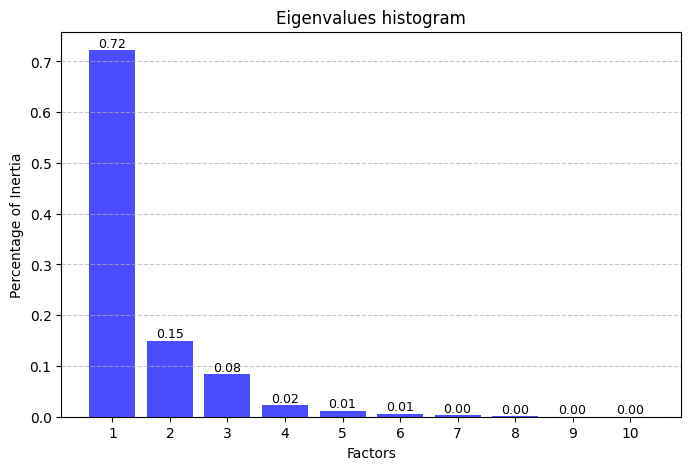

In [248]:
mypca.eigenval_plot()

In [249]:
mypca.var_plot()

Output()

#### **Coefficient de corrélation (Cos2) les plus remarquables sur les résultats de l'ACP par secteur :**
- Energy
    - **Composante principale retenue : CP2**
        - COS2 de % Change YTD pour CP2 : -0.61
    - PEG : 0.897
    - Price to Book Value : 0.80
    - EPS NTMA Growth 1 year : 0.60
    - Price to Free Cash Flow : -0.45
    - Dividend Yield : -0.72

- Utilities
    - **Composante principale retenue : CP3**
        - COS2 de % Change YTD pour CP3 : 0.79
    - EPS NTMA Growth 1 year : 0.65
    - PEG : 0.32
    - Return on Equity : 0.17
    - Price to Book Value : -0.03
    - Price to Cash Flow : -0.12

- Materials
    - **Composante principale retenue : CP1**
        - COS2 de % Change YTD pour CP1 : -0.63
    - Price to Cash Flow : 0.96
    - Price to Earnings : 0.96
    - Price to Sales : 0.96
    - Net Debt/EBITDA : -0.36
    - Dividend Yield : -0.65

- Financials
    - **Composante principale retenue : CP4**
        - COS2 de % Change YTD pour CP4 : 0.83
    - Price to Earnings : 0.16
    - PEG : 0.11
    - Price to Sales : 0.11
    - Assets/Equity : -0.21
    - Return on Equity : -0.12

- Industrials
    - **Composante principale retenue : CP4**
        - COS2 de % Change YTD pour CP4 : 0.76
    - Dividend Payout : 0.29
    - Assets/Equity : 0.25
    - PEG : 0.21
    - Gross Margin : 0.20
    - Net Debt/EBITDA : -0.31

- Health Care
    - **Composante principale retenue : CP3**
    - Gross Margin : 0.510
    - EBITDA Margin : 0.395
    - Dividend Payout : 0.344
    - Return on Equity : -0.259
    - EPS NTMA Growth : -0.416

- Real Estate
    - **Composante principale retenue : CP1**
        - COS2 de % Change YTD pour CP1 : -0.45
    - Enterprise Value to EBITDA : 0.97
    - Price to Sales : 0.99
    - Net Debt/EBITDA : -0.97
    - Assets/Equity : -0.59
    - Dividend Yield : -0.60
    
- Consumer Staples
    - **Composante principale retenue : CP1**
        - COS2 de % Change YTD pour CP1 : -0.48
    - Dividend Yield : -0.93
    - EPS NTMA Growth 1 year : -0.63
    - Enterprise Value to EBIT : 0.99
    - Enterprise Value to EBITDA : 0.99
    - Price to Cash Flow : 0.99

### **5. Régression linéaire sur le jeu de données préparé**
- variables indépendantes : données fondamentales en t
- variables dépendante : % Change YTD en t+1

In [251]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardisation des variables explicatives
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(dataset)

# Séparation de la variable cible (y) et des variables explicatives (X)
y = scaled_dataset[:,0]
X = scaled_dataset[:,1:]

# Entraînement du modèle de régression linéaire
reg = LinearRegression().fit(X, y)

# Calcul et affichage du score R2
r2_score = reg.score(X, y)
print(f"Score R2 : {r2_score:.2f}")

Score R2 : 1.00


In [252]:
# Extraction des coefficients de la régression et création d'une Series
X_coef = pd.Series(reg.coef_, index=dataset.columns[1:])

# Tri des coefficients par ordre décroissant
X_coef_sorted = X_coef.sort_values(ascending=False)
print(X_coef_sorted.round(3))

Metrics
Dividend Payout               3.726
Price to Free Cash Flow       2.389
Price to Sales                1.240
Return on Equity              1.211
EBIT Margin                   0.644
EBITDA Margin                 0.162
Enterprise Value to Sales    -0.106
Assets/Equity                -0.277
Price to Earnings            -0.338
Enterprise Value to EBITDA   -0.381
Enterprise Value to EBIT     -0.469
EPS NTMA Growth 1 year       -0.642
Dividend Yield               -0.664
PEG                          -1.060
Price to Book Value          -1.266
Gross Margin                 -1.396
Net Debt/EBITDA              -2.077
Price to Cash Flow           -3.203
dtype: float64


#### Affichage à titre d'illustration des valeurs prédites par le modèle et des valeurs réelles

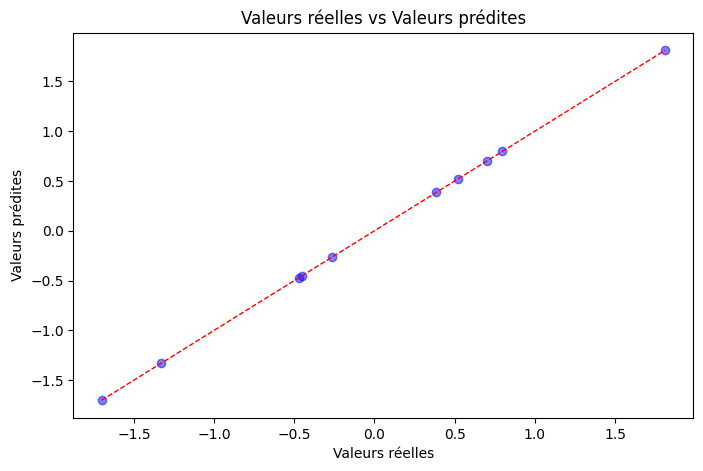

In [253]:
# Prédiction des valeurs avec le modèle
y_pred = reg.predict(X)

# Tracé des valeurs réelles (y) vs valeurs prédites (y_pred)
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred, alpha=0.5, color='blue')  # Nuage de points
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=1)  # Ligne de référence (y = x)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs réelles vs Valeurs prédites')
plt.show()

#### **Coefficients les plus remarquables sur les résultats de la régression linéaire**
- Energy
    - Price to Sales : 1.96
    - EPS NTMA Growth 1 year : 1.75
    - Price to Cash Flow : 1.01
    - PEG : -1.2
    - Dividend Payout : -1.06

- Utilities
    - PEG : 0.64
    - Price to Sales : -0.86
    - Dividend Yield : -1.47
    - Price to Book Value : -1.59
     - Dividend Payout : -1.89

- Materials
    - Gross Margin : 3.29
    - Price to Free Cash Flow : 2.24
    - Return on Equity : 0.90
    - Price to Cash Flow : -0.85
    - Net Debt/EBITDA : -2.17

- Financials
    - Dividend Yield : 500.81
    - Price to Book Value : 275.09
    - Dividend Payout : -491.55
    - Return on Equity : -196.52
    - EPS NTMA Growth 1 year : -114.32

- Industrials
    - Gross Margin : 1.08
    - Return on Equity : 1.00
    - Dividend Payout : 0.62
    - PEG : 0.53
    - Price to Cash Flow : -1.22

- Health Care
    - Price to Free Cash Flow : 0.920
    - Assets/Equity : 0.854
    - Price to Earnings : 0.434
    - PEG : -1.163
    - EPS NTMA Growth 1 year : -1.318

- Real Estate
    - Assets/Equity : 0.65
    - Price to Earnings : 0.62
    - Price to Sales : 0.36
    - Net Debt/EBITDA : -3.58
    - Price to Book Value : -3.01
    - PEG : -2.11

- Consumer Staples
    - Price to Cash Flow : -3.20
    - Net Debt/EBITDA : -2.08
    - EBIT Margin : 0.64
    - Dividend Payout : 3.73
    - Return on Equity : 1.21